In [1]:
import sys

sys.path.append("..")

In [2]:
import json
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
from tqdm import tqdm
from datasets import load_dataset
from scipy.stats import norm, multivariate_normal
import ast

from src.vae.modeling import BetaVAE

seed = 42
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/home/bruno/miniconda3/envs/music-gen-interpretability/lib/python3.12/site-packages/torchmetrics/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


Using device: cuda


## Define Tag Categories

Define all possible tags for each category based on the dataset.

In [3]:
TAXONOMY = json.load(open("../data/concepts_to_tags.json", "r"))

CATEGORIES = list(TAXONOMY.keys())

# Reverse map for easy lookup (tag -> category)
TAG_TO_CATEGORY = {}
for cat, tags in TAXONOMY.items():
    for tag in tags:
        TAG_TO_CATEGORY[tag] = cat


In [4]:
tag_to_idx = {}
idx_to_tag = {}
cat_ranges = {} # Stores start/end index for each category

current_idx = 0
for cat in CATEGORIES:
    start = current_idx
    for tag in TAXONOMY[cat]:
        tag_to_idx[tag] = current_idx
        idx_to_tag[current_idx] = (cat, tag)
        current_idx += 1
    cat_ranges[cat] = (start, current_idx)

TOTAL_INPUT_DIM = current_idx
print(f"Total Input Dimension: {TOTAL_INPUT_DIM}")

Total Input Dimension: 200


## Generate tags

In [5]:
df = pd.read_csv("../data/mtg_jamendo/autotagging_top50tags_processed_cleaned.csv")
df['aspect_list'] = df['aspect_list'].apply(ast.literal_eval)
df['instrument_tags'] = df['instrument_tags'].apply(ast.literal_eval)
df['genre_tags'] = df['genre_tags'].apply(ast.literal_eval)
df['mood_tags'] = df['mood_tags'].apply(ast.literal_eval)
df

,id,tags,genre_tags,mood_tags,instrument_tags,aspect_list
0,track_0007391,"['genre---electronic', 'genre---pop', 'instrum...","[electronic, pop]",[emotional],"[bass, drums, guitar, keyboard]","[drums, bass, guitar, electronic, emotional, p..."
1,track_0015161,"['genre---instrumentalpop', 'genre---pop', 'ge...","[pop, rock]",[emotional],"[bass, drums]","[drums, bass, rock, emotional, pop]"
2,track_0015166,"['genre---dance', 'genre---electronic', 'genre...","[dance, electronic, pop, techno]",[emotional],[bass],"[bass, electronic, dance, techno, emotional, pop]"
3,track_0015167,"['genre---chillout', 'genre---easylistening', ...","[electronic, pop]",[emotional],"[bass, violin]","[bass, electronic, emotional, pop, violin]"
4,track_0015169,"['genre---electronic', 'genre---instrumentalpo...","[electronic, pop]",[emotional],"[bass, drums]","[drums, bass, electronic, emotional, pop]"
...,...,...,...,...,...,...
2036,track_1420702,"['genre---dance', 'genre---easylistening', 'ge...",[dance],"[funk, happy]","[bass, drums, keyboard]","[drums, bass, dance, funk, keyboard, happy]"
2037,track_1420704,"['genre---dance', 'genre---easylistening', 'in...",[dance],[happy],"[bass, drums, keyboard]","[drums, bass, dance, keyboard, happy]"
2038,track_1420705,"['genre---dance', 'genre---easylistening', 'in...",[dance],[happy],"[bass, drums, keyboard]","[drums, bass, dance, keyboard, happy]"
2039,track_1420706,"['genre---dance', 'genre---easylistening', 'in...",[dance],[happy],"[bass, drums, keyboard]","[drums, bass, dance, keyboard, happy]"


In [6]:
input_dim = TOTAL_INPUT_DIM
latent_dim = 128
hidden_dim = 512
dropout_p = 0.25
use_batch_norm = False
beta = 0.25

model = BetaVAE(input_dim, latent_dim, hidden_dim, dropout_p, use_batch_norm, beta).to(device)
model.load_state_dict(torch.load("../models/vae_final.pth", map_location=device))
model.eval()

print("✓ Best model loaded successfully")

✓ Best model loaded successfully


Encoding data to latent space: 100%|██████████| 2041/2041 [00:00<00:00, 3791.92it/s]


Latent representations obtained.
t-SNE transformation completed.


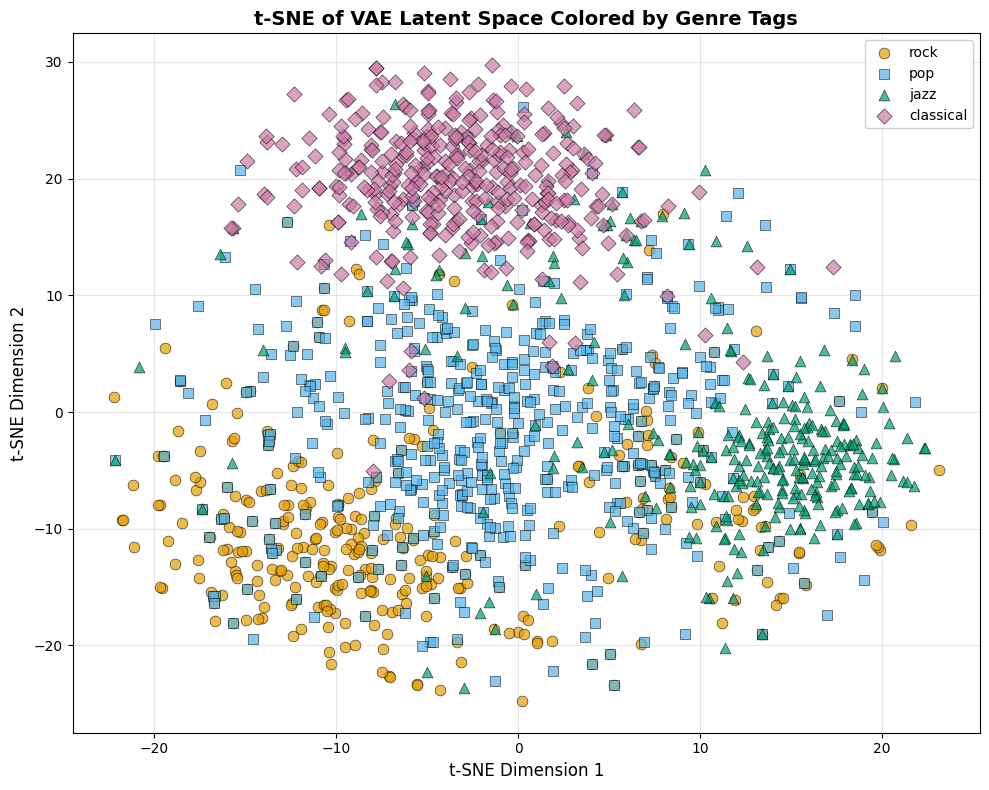

In [7]:
# Visualise latent space as t-sne plot
# Compare clusters based on different genre tags
from sklearn.manifold import TSNE

def get_latent_representations(model, data):
    latents = []
    with torch.no_grad():
        for x in tqdm(data, desc="Encoding data to latent space"):
            x_tensor = torch.FloatTensor(x).unsqueeze(0).to(device)
            mu, logvar = model.encode(x_tensor)
            z = model.reparameterize(mu, logvar)
            latents.append(z.cpu().numpy().squeeze())
    return np.array(latents)

# Prepare data
data = []
for _, row in df.iterrows():
    x = np.zeros(TOTAL_INPUT_DIM, dtype=np.float32)
    for tag in row['aspect_list']:
        if tag in tag_to_idx:
            x[tag_to_idx[tag]] = 1.0
    data.append(x)
data = np.array(data)

latents = get_latent_representations(model, data)
print("Latent representations obtained.")

tsne = TSNE(n_components=2, random_state=seed)
latents_2d = tsne.fit_transform(latents)
print("t-SNE transformation completed.")

# Plotting with colorblind-friendly palette and different markers
plt.figure(figsize=(10, 8))

# Colorblind-friendly palette (Wong 2011) with distinct markers
genre_styles = {
    'rock': {'color': '#E69F00', 'marker': 'o'},      # Orange
    'pop': {'color': '#56B4E9', 'marker': 's'},       # Sky Blue
    'jazz': {'color': '#009E73', 'marker': '^'},      # Bluish Green
    'classical': {'color': '#CC79A7', 'marker': 'D'}  # Reddish Purple
}

for genre, style in genre_styles.items():
    indices = []
    for i, row in df.iterrows():
        if genre in row['genre_tags']:
            indices.append(i)
    
    if len(indices) > 0:
        plt.scatter(
            latents_2d[indices, 0], 
            latents_2d[indices, 1], 
            label=genre, 
            alpha=0.7, 
            c=style['color'],
            marker=style['marker'],
            s=60,
            edgecolors='black',
            linewidths=0.5
        )

plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.title("t-SNE of VAE Latent Space Colored by Genre Tags", fontsize=14, fontweight='bold')
plt.xlabel("t-SNE Dimension 1", fontsize=12)
plt.ylabel("t-SNE Dimension 2", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../docs/assets/tsne_genre_clusters.pdf", bbox_inches='tight')
plt.show()

In [28]:
def generate_tags_with_threshold(model, latent_vector, seed_tags=None, threshold=0.5, temp=1.0):
    model.eval()
    with torch.no_grad():
        latent_tensor = torch.FloatTensor(latent_vector).unsqueeze(0).to(device)
        recon_x = model.decode(latent_tensor)
        recon_x = torch.sigmoid(recon_x / temp).squeeze().cpu().numpy()
    
    if seed_tags:
        for tag in seed_tags:
            if tag in tag_to_idx:
                idx = tag_to_idx[tag]
                recon_x[idx] = 1.0  # Force seed tags to be present

    predicted_tags = []
    for idx, prob in enumerate(recon_x):
        if prob >= threshold:
            cat, tag = idx_to_tag[idx]
            predicted_tags.append(tag)
    
    return predicted_tags

In [31]:
for i in range(5):
    random_latent = np.random.normal(0, 1, latent_dim)
    seed_tags = ['rock', 'guitar'] if i % 2 == 0 else ['classical', 'piano']
    temp = [0.7, 1.0, 1.2][i % 3]
    generated_tags = generate_tags_with_threshold(model, random_latent, seed_tags=seed_tags, threshold=0.52, temp=temp)
    print(f"Seed Tags: {seed_tags}, Temp: {temp} -> Generated Tags: {generated_tags}")

Seed Tags: ['rock', 'guitar'], Temp: 0.7 -> Generated Tags: ['medium tempo', 'groovy', 'rock', 'r&b', 'eerie', 'soft rock', 'dark', 'electronic drums', 'groovy bass line', 'guitar']
Seed Tags: ['classical', 'piano'], Temp: 1.0 -> Generated Tags: ['classical', 'soothing', 'ethereal', 'piano', 'no percussion', 'no voice']
Seed Tags: ['rock', 'guitar'], Temp: 1.2 -> Generated Tags: ['rock', 'fun', 'electric guitar', 'no voices', 'guitar']
Seed Tags: ['classical', 'piano'], Temp: 0.7 -> Generated Tags: ['medium tempo', 'groovy', 'classical', 'playful', 'gentle', 'electric guitar', 'piano', 'male voice', 'percussion', 'no singer', 'violin']
Seed Tags: ['rock', 'guitar'], Temp: 1.0 -> Generated Tags: ['rock', 'acoustic guitar', 'female vocal', 'orchestra', 'guitar']


In [32]:
N_SAMPLES_TO_GENERATE = len(df)
latents = np.random.normal(0, 1, (N_SAMPLES_TO_GENERATE, latent_dim)).astype(np.float32)

In [51]:
threshold = 0.52
temperatures = [0.25, 0.5, 0.75, 1.0, 1.0, 1.0, 1.25, 1.5, 1.75, 2.0]
N_SAMPLES_TO_GENERATE = len(df)

results = []
for temp in tqdm(temperatures, desc="Temperatures"):
    for idx in tqdm(range(N_SAMPLES_TO_GENERATE), desc="Samples", leave=False):
        row = df.iloc[idx]
        seed_tags = []

        for category in ['genre', 'instrument', 'mood']:
            if len(row[f"{category}_tags"]) > 1:
                seed_tags.append(np.random.choice(row[f"{category}_tags"]))

        latent_vector = latents[idx:idx+1]
            
        generated_tags = generate_tags_with_threshold(model, latent_vector, seed_tags=seed_tags, threshold=threshold, temp=temp)

        df_entry = {
            'id': row['id'],
            'aspect_list': generated_tags,
            'original_aspect_list': row['aspect_list'],
            'temperature': temp,
        }
        results.append(df_entry)

# Add random latent vector generation for variety
for idx in tqdm(range(N_SAMPLES_TO_GENERATE * len(temperatures)), desc="Samples", leave=False):
    idx %= N_SAMPLES_TO_GENERATE  # Wrap around to existing data indices
    z = latents[idx:idx+1]  # Keep batch dimension
    
    generated_tags = generate_tags_with_threshold(model, z, seed_tags=[], threshold=threshold, temp=temp)
    
    df_entry = {
        'id': df.iloc[idx]['id'],
        'aspect_list': generated_tags,
        'original_aspect_list': [],
        'temperature': temp,
    }
    
    results.append(df_entry)

Temperatures: 100%|██████████| 10/10 [00:11<00:00,  1.16s/it]


In [52]:
res_df = pd.DataFrame(results)
res_df

,id,aspect_list,original_aspect_list,temperature
0,track_0007391,"[medium tempo, slow tempo, pop, ambient, cinem...","[drums, bass, guitar, electronic, emotional, p...",0.25
1,track_0015161,"[slow tempo, pop, cinematic, energetic, exciti...","[drums, bass, rock, emotional, pop]",0.25
2,track_0015166,"[groovy piano chords, techno, emotional, passi...","[bass, electronic, dance, techno, emotional, pop]",0.25
3,track_0015167,"[medium tempo, groovy, pop, playful, acoustic ...","[bass, electronic, emotional, pop, violin]",0.25
4,track_0015169,"[groovy piano chords, 4 on the floor kick patt...","[drums, bass, electronic, emotional, pop]",0.25
...,...,...,...,...
40815,track_1420702,[fast tempo],[],2.00
40816,track_1420704,"[medium fast tempo, rock, energetic, male voca...",[],2.00
40817,track_1420705,"[medium tempo, fast tempo, groovy, happy, exci...",[],2.00
40818,track_1420706,"[moderate tempo, male voice, no voices, bass]",[],2.00


In [53]:
# Sort aspect list column and deduplicate tag combinations
res_df['aspect_list'] = res_df['aspect_list'].apply(lambda x: sorted(list(set(x))))
# CAtegorize aspect list
res_df['instrument_tags'] = res_df['aspect_list'].apply(lambda tags: [tag for tag in tags if TAG_TO_CATEGORY.get(tag) == 'instrument'])
res_df['genre_tags'] = res_df['aspect_list'].apply(lambda tags: [tag for tag in tags if TAG_TO_CATEGORY.get(tag) == 'genre'])
res_df['mood_tags'] = res_df['aspect_list'].apply(lambda tags: [tag for tag in tags if TAG_TO_CATEGORY.get(tag) == 'mood'])
res_df['tempo_tags'] = res_df['aspect_list'].apply(lambda tags: [tag for tag in tags if TAG_TO_CATEGORY.get(tag) == 'tempo'])
# Remove samples with tags in less than 3 categories
res_df = res_df[
    res_df.apply(
        lambda row: sum(
            1 for cat in ['instrument_tags', 'genre_tags', 'mood_tags', 'tempo_tags'] if len(row[cat]) > 0
        ) >= 3,
        axis=1
    )
].reset_index(drop=True)
res_df

,id,aspect_list,original_aspect_list,temperature,instrument_tags,genre_tags,mood_tags,tempo_tags
0,track_0007391,"[ambient, bass, cinematic, dark, digital drums...","[drums, bass, guitar, electronic, emotional, p...",0.25,"[bass, digital drums, strings]","[ambient, cinematic, pop, rap]","[dark, eerie, emotional, ethereal, gentle, int...","[medium tempo, slow tempo]"
1,track_0015161,"[acoustic guitar, cheerful, cinematic, drums, ...","[drums, bass, rock, emotional, pop]",0.25,"[acoustic guitar, drums, female voice, keyboar...","[cinematic, pop]","[cheerful, energetic, exciting, mysterious]",[slow tempo]
2,track_0015166,"[emotional, flat male vocal, fun, groovy bass,...","[bass, electronic, dance, techno, emotional, pop]",0.25,"[flat male vocal, groovy bass, passionate fema...",[techno],"[emotional, fun, happy, passionate]",[groovy piano chords]
3,track_0015167,"[acoustic drums, acoustic guitar, bass, bass g...","[bass, electronic, emotional, pop, violin]",0.25,"[acoustic drums, acoustic guitar, bass, bass g...",[pop],[playful],"[groovy, medium tempo]"
4,track_0015169,"[4 on the floor kick pattern, ambient, bass, c...","[drums, bass, electronic, emotional, pop]",0.25,"[bass, claps, groovy bass, male singer, passio...","[ambient, electro pop, hip hop, pop]","[emotional, energetic, exciting, fun, happy]","[4 on the floor kick pattern, groovy piano cho..."
...,...,...,...,...,...,...,...,...
23810,track_1420513,"[cheerful, fast tempo, happy, percussion, upbeat]",[],2.00,[percussion],[],"[cheerful, happy]","[fast tempo, upbeat]"
23811,track_1420556,"[emotional, intense, medium tempo, mellow, ste...",[],2.00,[steady drumming],[],"[emotional, intense, mellow]",[medium tempo]
23812,track_1420578,"[electric guitar, energetic, groovy, groovy ba...",[],2.00,"[electric guitar, groovy bass]",[],"[energetic, intense]","[groovy, medium fast tempo]"
23813,track_1420704,"[energetic, male vocalist, medium fast tempo, ...",[],2.00,[male vocalist],[rock],[energetic],[medium fast tempo]


In [54]:
# Add surrogate key based on track_id, original_tags and temperature
import hashlib
def generate_surrogate_key(track_id: str, original_tags: str, temperature: float) -> str:
    key_str = f"{track_id}_{original_tags}_{temperature}"
    return hashlib.md5(key_str.encode()).hexdigest()

res_df['surrogate_key'] = res_df.apply(lambda row: generate_surrogate_key(row['id'], row['original_aspect_list'], row['temperature']), axis=1)
res_df.drop(columns=['id'], inplace=True)
res_df.rename(columns={'surrogate_key': 'id'}, inplace=True)
res_df

,aspect_list,original_aspect_list,temperature,instrument_tags,genre_tags,mood_tags,tempo_tags,id
0,"[ambient, bass, cinematic, dark, digital drums...","[drums, bass, guitar, electronic, emotional, p...",0.25,"[bass, digital drums, strings]","[ambient, cinematic, pop, rap]","[dark, eerie, emotional, ethereal, gentle, int...","[medium tempo, slow tempo]",a5274f9fdb13dc7efcf1d9f7f00f6916
1,"[acoustic guitar, cheerful, cinematic, drums, ...","[drums, bass, rock, emotional, pop]",0.25,"[acoustic guitar, drums, female voice, keyboar...","[cinematic, pop]","[cheerful, energetic, exciting, mysterious]",[slow tempo],21e12f6468a48b39026377df20df0d00
2,"[emotional, flat male vocal, fun, groovy bass,...","[bass, electronic, dance, techno, emotional, pop]",0.25,"[flat male vocal, groovy bass, passionate fema...",[techno],"[emotional, fun, happy, passionate]",[groovy piano chords],b587b6989b234ffcd75db150bdc3b0bc
3,"[acoustic drums, acoustic guitar, bass, bass g...","[bass, electronic, emotional, pop, violin]",0.25,"[acoustic drums, acoustic guitar, bass, bass g...",[pop],[playful],"[groovy, medium tempo]",1a99f6b9e15f1bd35a1a0b272e78d2fb
4,"[4 on the floor kick pattern, ambient, bass, c...","[drums, bass, electronic, emotional, pop]",0.25,"[bass, claps, groovy bass, male singer, passio...","[ambient, electro pop, hip hop, pop]","[emotional, energetic, exciting, fun, happy]","[4 on the floor kick pattern, groovy piano cho...",8e0f1794d255b496e0689412618ba906
...,...,...,...,...,...,...,...,...
23810,"[cheerful, fast tempo, happy, percussion, upbeat]",[],2.00,[percussion],[],"[cheerful, happy]","[fast tempo, upbeat]",91ebde6224b7a58cf34d6b0e14e5935d
23811,"[emotional, intense, medium tempo, mellow, ste...",[],2.00,[steady drumming],[],"[emotional, intense, mellow]",[medium tempo],938aaac2ca856fb6b0cd268bb5633322
23812,"[electric guitar, energetic, groovy, groovy ba...",[],2.00,"[electric guitar, groovy bass]",[],"[energetic, intense]","[groovy, medium fast tempo]",a82e2af347a3990273b65da10ff977ee
23813,"[energetic, male vocalist, medium fast tempo, ...",[],2.00,[male vocalist],[rock],[energetic],[medium fast tempo],0a8dee65f501cbc82485539a72f46c35


## Push to Hugginface Hub

In [55]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(res_df, test_size=0.1, random_state=42)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=42)

In [56]:
from pathlib import Path

# Create output directory
output_dir = Path("../data/vae-tags-dataset")
output_dir.mkdir(parents=True, exist_ok=True)

df_train.to_csv(output_dir / "train.csv", index=False)
df_valid.to_csv(output_dir / "validation.csv", index=False)
df_test.to_csv(output_dir / "test.csv", index=False)
all_df = pd.concat([df_train, df_valid, df_test])
all_df.to_csv(output_dir / "all.csv", index=False)

In [57]:
data_files = {
    "train": str(output_dir / "train.csv"),
    "validation": str(output_dir / "validation.csv"),
    "test": str(output_dir / "test.csv")
}
dataset = load_dataset("csv", data_files=data_files)
dataset.push_to_hub("bsienkiewicz/vae-tags-dataset", private=True)

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md:   0%|          | 0.00/815 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/bsienkiewicz/vae-tags-dataset/commit/68335f08cffbae9c7465dfc19a07d57dd16aa106', commit_message='Upload dataset', commit_description='', oid='68335f08cffbae9c7465dfc19a07d57dd16aa106', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/bsienkiewicz/vae-tags-dataset', endpoint='https://huggingface.co', repo_type='dataset', repo_id='bsienkiewicz/vae-tags-dataset'), pr_revision=None, pr_num=None)